# K-Nearest Neighbors
<p>KNN is a form of <i>instance</i>, or <i>memory</i> based learning wherein we don't learn a function $f(X)$ to estimate $E[Y|X]$. Rather, to make a classification for a given instance $X_i$, we search the training data for the $k$ nearest neighbors, as defined by some distance metric $d(X_i,X_j)$. The estimate of $E[Y|X]$ is then given by:<br><br>

<center>$E[Y|X] = \sum\limits_{y_i \in N(X)}^k Y_i$</center><br><br>

The most common distance function used in kNN is the <i>Euclidean Distance</i>.<br><br>

Let $X = <x^1,...x^p>$ be a $p$-dimensional vector, then for two instances $i$ and $j$:<br><br>
<center>$eud(X_i,X_j) = \sqrt{(x_i^1-x_j^1)^2+...+(x_i^p-x_j^p)^2} = \sqrt{\sum\limits_{t=1}^p (x_i^t-x_j^t)^2}$
</center>
<br><br>
In the following example we run kNN on some real data from an ad conversion prediction dataset.
</p>

In [2]:
'''
This block loads the data, downsamples it, splits to train/test and rescales it.
'''

import pandas as pd
import sys
#sys.path.append("C:/Users/kevin/Documents/GitHub/DS_course/ipython")

#Get the datadir path set up - note this may only work in Linux/MAC
import os
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/data/'
#If it doesn't work, hard code the datadir
#datadir = ${path}


import numpy as np
import course_utils as bd
import imp
imp.reload(bd)
import matplotlib.pyplot as plt


#KNN is implemented as a class in sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

#Load data and downsample for a 50/50 split, then split into a train/test
f = datadir + 'ads_dataset_cut.txt'

train_split = 0.5

tdat = pd.read_csv(f, header = 0, sep = '\t')
moddat = bd.evenSplit(tdat,'y_buy')
moddat_scale =bd.scaleData(moddat)

#We know the dataset is sorted so we can just split by index
train = moddat[:int(np.floor(moddat.shape[0] * train_split))]
test = moddat[int(np.floor(moddat.shape[0] * train_split)):]

#Scale the data to [0,1] interval...note that scaleData doesn't rescale by variance
train_scale = moddat_scale[:int(np.floor(moddat_scale.shape[0] * train_split))]
test_scale = moddat_scale[int(np.floor(moddat_scale.shape[0] * train_split)):]


In [3]:

def testKnn(k, train, test, lab, p = 2):
    '''
    Run kNN classification and return accuracy 
    '''
    X_train = train.drop(lab, 1)
    y_train = train[lab]
    #Specify k and use p=2 for Euclidean distance
    neigh = KNeighborsClassifier(n_neighbors = k, p = p)
    #doesn't really fit the model in a classic sense, it does some intelligent partitioning of the data
    neigh.fit(X_train, y_train)
    #Get the predictions...note, this returns a class label prediction, not a probability
    cm = confusion_matrix(neigh.predict(test.drop(lab, 1)), test[lab])
    return (cm[0][0] + cm[1][1]) / float(np.sum(cm))

<p>Given a feature set and a distance function, the paramater that controls complexity is the number of neighbors used $k$. Like with all complexity parameters, the optimal value is dependent on the data, and is generally the one that exploits the best bias-variance tradeoff. <br><br>

The following is an example grid search to find the optimal $k$. We also create 2 other variants of the data to show the effect of each on accuracy.<br>

<ul>
    <li>The training set size</li>
    <li>The scaling of the features</li>
</ul><br>

Note that Euclidean distance is not scale invariant. Features with higher norms will in general dominate the neighborhood. If the features with the highest norms are also not that predictive, then the model predictions suffer. It is often best to rescale the features before running kNN.


</p>

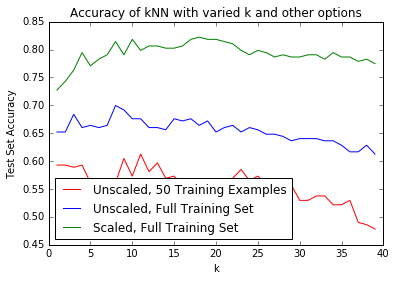

In [4]:
go=1
if (go==1):
    s1=[ testKnn(i, train[:50], test,'y_buy', p = 2) for i in range(1, 40) ]
    s2=[ testKnn(i, train, test, 'y_buy', p = 2) for i in range(1, 40) ]
    s3=[ testKnn(i, train_scale, test_scale, 'y_buy', p = 2) for i in range(1, 40) ]
    
x = range(1, 40)
    
fig = plt.figure()
ax = fig.add_subplot(111)
p1 = plt.plot(x,s1,'r-', label = 'Unscaled, 50 Training Examples')
p2 = plt.plot(x,s2,'b-', label = 'Unscaled, Full Training Set')
p3 = plt.plot(x,s3,'g-', label = 'Scaled, Full Training Set')
plt.title('Accuracy of kNN with varied k and other options')
plt.legend(loc = 3)
ax.set_xlabel('k')
ax.set_ylabel('Test Set Accuracy')
plt.show()

<p>One major challenge with kNN is that the expected distance between any two points in $p$-dimensional space increases as $p$ increases. The following is a simulation that illustrates this concept.<br><br>

We generate $n$ uniformly distributed samples in a $p$-dimensional hyper-cube. We then show the average distance between instances increases as we consider more dimensions.

</p>

/Users/briand/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


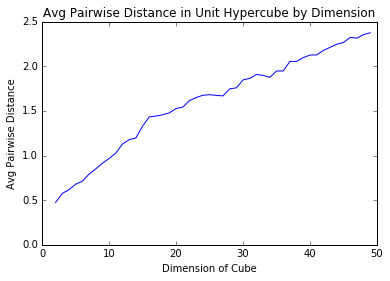

In [5]:
'''
Show curse of dimensionality
'''
import numpy as np

#Generate a random matrix in a uniform hyper-cube

n = 100
d = 50
X = np.random.rand(n, d)

dims = range(2, d)
dists = dict()

go = 1
if (go==1):
    for dim in dims:
        dists[dim] = list()

    #Now get all pairwise distances of various dimensions
    for i in range(n):
        for j in range(i + 1, n):
            for dim in dims:
                dists[dim].append(np.sqrt((sum((X[i, :dim] - X[j, :dim])**2))))

    means=[ np.array(dists[dim]).mean() for dim in dims ]


    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(dims,means)
plt.title('Avg Pairwise Distance in Unit Hypercube by Dimension')
plt.legend(loc=3)
ax.set_xlabel('Dimension of Cube')
ax.set_ylabel('Avg Pairwise Distance')
plt.show()



<p>Now we plot this histogram of distances, and not just the mean distance by dimension $p$.</p>

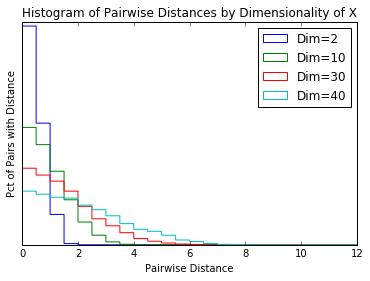

In [6]:
'''
Plot histogram of pairwise distances
'''
import matplotlib.pyplot as plt

r = (0,12)
b = 24
fig = plt.figure()
frame = plt.gca()
ax = fig.add_subplot(111)
h1 = plt.hist(dists[2], range=r, bins=b, normed=True, histtype='step',stacked=True,label='Dim=2')
h2 = plt.hist(dists[10],range=r, bins=b, normed=True, histtype='step',stacked=True,label='Dim=10')
h3 = plt.hist(dists[20],range=r, bins=b, normed=True, histtype='step',stacked=True,label='Dim=30')
h4 = plt.hist(dists[40],range=r, bins=b, normed=True, histtype='step',stacked=True,label='Dim=40')
frame.axes.get_yaxis().set_ticks([])
ax.set_xlabel('Pairwise Distance')
ax.set_ylabel('Pct of Pairs with Distance')
plt.title('Histogram of Pairwise Distances by Dimensionality of X')
plt.legend()
plt.show()
